In [101]:
import os
from pathlib import Path
import pickle

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images


In [102]:
ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

In [103]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [104]:
# class CFG:
#     model_type = 'CatBoost'
#     popular_num_items = 12
#     popular_days = 7
#     train_weeks = 3
#     repurchase_weeks = 12345
#     repurchase_num_items = 100
#     item2item_weeks = 12345
#     item2item_num_items = 24
#     cooc_weeks = 12
#     cooc_threshold = 50
#     dynamic_feature_weeks = 8
#     volume_feature_days = 7
#     volume_feature_blocks = 1


# BEST
class CFG:
    model_type = 'CatBoost'
    popular_num_items = 24
    popular_days = 7
    train_weeks = 3
    repurchase_weeks = 123456
    repurchase_num_items = 123456
    item2item_weeks = 123456
    item2item_num_items = 24
    cooc_weeks = 12
    cooc_threshold = 50
    dynamic_feature_weeks = 8
    volume_feature_days = 7
    volume_feature_blocks = 1

In [105]:
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks+1}.pkl")
assert os.path.exists(ARTIFACTS_DIR / f"lfm_{dataset}_{CFG.train_weeks}.pkl")

In [106]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            max_items_per_user: int) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
        day_start = 7 * week_start
        tr = transactions.query("@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(CFG.popular_num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_num: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        week_end = week_start + week_num
        # TODO: 元々バグってたので閾値とか要検討
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, CFG.repurchase_weeks, CFG.repurchase_num_items)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week)

    candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.repurchase_weeks, CFG.item2item_num_items)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [107]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 1
volume: 13182061
duplicates: 1.0577097472372656
            strategy   volume     ratio
0  same_product_code  6876142  0.521629
1         repurchase  3446562  0.261459
2                pop  1655616  0.125596
3               cooc  1203741  0.091317
week: 2
volume: 14012387
duplicates: 1.0627531904278706
            strategy   volume     ratio
0  same_product_code  7228749  0.515883
1         repurchase  3637145  0.259566
2                pop  1728456  0.123352
3               cooc  1418037  0.101199
week: 3
volume: 14832068
duplicates: 1.0663234010614298
            strategy   volume     ratio
0  same_product_code  7678831  0.517718
1         repurchase  3742824  0.252347
2                pop  1819728  0.122689
3               cooc  1590685  0.107246
week: 4
volume: 15816758
duplicates: 1.069944615296363
            strategy   volume     ratio
0  same_product_code  8177755  0.517031
1         repurchase  3915353  0.247545
2                pop  1926072  0.121774
3               c

In [108]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [109]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


week: 0
Recall: 0.11851980086839348
            strategy       y   volume    recall  hit_ratio
0         repurchase  8437.0  3446562  0.039475   0.002448
1                pop  8434.0  1655616  0.039461   0.005094
2  same_product_code  7888.0  6876142  0.036907   0.001147
3               cooc  5096.0  1203741  0.023843   0.004233
week: 1
Recall: 0.11020578298451143
            strategy       y   volume    recall  hit_ratio
0         repurchase  8955.0  3637145  0.039292   0.002462
1  same_product_code  8554.0  7228749  0.037532   0.001183
2                pop  7196.0  1728456  0.031574   0.004163
3               cooc  5210.0  1418037  0.022860   0.003674
week: 2
Recall: 0.11334711056226215
            strategy       y   volume    recall  hit_ratio
0         repurchase  9195.0  3742824  0.038622   0.002457
1  same_product_code  8829.0  7678831  0.037085   0.001150
2                pop  8558.0  1819728  0.035947   0.004703
3               cooc  5376.0  1590685  0.022581   0.003380
week: 3

In [110]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 13182061 -> 4053470
drop trivial queries: 14012387 -> 4225003
drop trivial queries: 14832068 -> 4562580
drop trivial queries: 15816758 -> 4819223


In [111]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['age']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # user dynamic features (item category stats)
    week_end = week + CFG.dynamic_feature_weeks
    tr = transactions.query("@week <= week < @week_end").merge(items, on='item')
    cat_cols = [
        # 'product_type_no_idx', 'product_group_name_idx',
        # 'graphical_appearance_no_idx', 'colour_group_code_idx',
        # 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx',
        # 'department_no_idx',
        'index_code_idx', 'index_group_no_idx',
        # 'section_no_idx',
        'garment_group_no_idx'
    ]

    for col in cat_cols:
        print(f'processing {col}')
        tmp = tr.groupby(['user', col]).size().reset_index(name='cnt')
        tmp2 = tr.groupby(['user']).size().reset_index(name='user_cnt')
        tmp = tmp.merge(tmp2, on='user')
        tmp['rate'] = tmp['cnt'] / tmp['user_cnt']

        vs = sorted(items[col].unique())
        print(f'#unique values: {len(vs)}')
        for v in tqdm(vs):
            col_name = f'user_{col}_{v}_rate'
            df = (df
                  .merge(tmp.query(f'{col} == @v')[['user', 'rate']], on='user', how='left')
                  .rename(columns={'rate': col_name + '_tmp'})
                  )
            df[col_name] = pd.arrays.SparseArray(df[col_name + '_tmp'].fillna(0).values)
            del df[col_name + '_tmp']

    # item dynamic features (transactions)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    week_end = week + CFG.dynamic_feature_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
    tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name=f'item_volume_{i}')
        df = df.merge(tmp, on='item', how='left')

    # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
    # tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
    # df = df.merge(tmp, on='user', how='left')

    # user volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('user').size().reset_index(name=f'user_volume_{i}')
        df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
    tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    for i in range(CFG.volume_feature_blocks):
        day_start = 7 * week
        day_end = day_start + (i+1) * CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    # lfm features
    lfm_path = ARTIFACTS_DIR / f"lfm_{dataset}_{pretrain_week}.pkl"

    with open(lfm_path, 'rb') as f:
        lfm = pickle.load(f)
    no_components = lfm.get_params()['no_components']

    # df['lfm'] = lfm.predict(df['user'].values, df['item'].values, num_threads=psutil.cpu_count(logical=False))

    user_reps = np.hstack([lfm.user_embeddings, lfm.user_biases.reshape((len(users), 1))])
    user_reps = pd.DataFrame(user_reps, columns=[f'user_rep_{i}' for i in range(no_components+1)])
    user_reps = pd.concat([pd.DataFrame({'user': range(len(users))}), user_reps], axis=1)
    df = df.merge(user_reps, on='user')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

week: 1
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 2
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 3
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 4
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [ ]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [ ]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


In [ ]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


In [ ]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

In [ ]:
def get_sparse(df, feature_columns):
    df = df.apply(pd.arrays.SparseArray)
    X = df[feature_columns]
    return X

In [ ]:
X_train = get_sparse(train, feature_columns)
X_valid = get_sparse(valid, feature_columns)

In [ ]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)
    train_tmp = train[['y']].copy()
    valid_tmp = valid[['y']].copy()
    del train, valid

    train_dataset = lgb.Dataset(X_train, train_tmp['y'], group=group_train, feature_name=feature_columns)
    valid_dataset = lgb.Dataset(X_valid, valid_tmp['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_tmp = train[['y', 'query_group']].copy()
    valid_tmp = valid[['y', 'query_group']].copy()
    
    del train, valid
    
    train_pool = catboost.Pool(data=X_train, label=train_tmp['y'], group_id=train_tmp['query_group'], cat_features=cat_features, feature_names=feature_columns)
    valid_pool = catboost.Pool(data=X_valid, label=valid_tmp['y'], group_id=valid_tmp['query_group'], cat_features=cat_features, feature_names=feature_columns)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [ ]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
X_valid_all = get_sparse(dataset_valid_all, feature_columns)
pred['pred'] = model.predict(X_valid_all)

In [ ]:
pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

In [ ]:
gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

In [124]:
print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03346993468264417


In [ ]:
assert False

submission

In [125]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

week: 1
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 2
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 3
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 4
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

In [126]:
X_train = get_sparse(train, feature_columns)
train_tmp = train[['y', 'query_group', 'user']].copy()

del train

0:	total: 3.27s	remaining: 53m 42s
1:	total: 6.51s	remaining: 53m 24s
2:	total: 9.74s	remaining: 53m 13s
3:	total: 13s	remaining: 53m 8s
4:	total: 16.2s	remaining: 53m 4s
5:	total: 19.5s	remaining: 53m 9s
6:	total: 22.8s	remaining: 53m 7s
7:	total: 26.2s	remaining: 53m 19s
8:	total: 29.5s	remaining: 53m 18s
9:	total: 32.7s	remaining: 53m 13s
10:	total: 36s	remaining: 53m 12s
11:	total: 39.4s	remaining: 53m 14s
12:	total: 43.1s	remaining: 53m 42s
13:	total: 46.3s	remaining: 53m 35s
14:	total: 49.5s	remaining: 53m 27s
15:	total: 52.8s	remaining: 53m 22s
16:	total: 56.1s	remaining: 53m 17s
17:	total: 59.3s	remaining: 53m 8s
18:	total: 1m 2s	remaining: 53m 2s
19:	total: 1m 5s	remaining: 52m 58s
20:	total: 1m 9s	remaining: 52m 52s
21:	total: 1m 12s	remaining: 52m 47s
22:	total: 1m 15s	remaining: 52m 45s
23:	total: 1m 18s	remaining: 52m 44s
24:	total: 1m 22s	remaining: 52m 42s
25:	total: 1m 25s	remaining: 52m 40s
26:	total: 1m 28s	remaining: 52m 39s
27:	total: 1m 32s	remaining: 52m 36s
28:	t

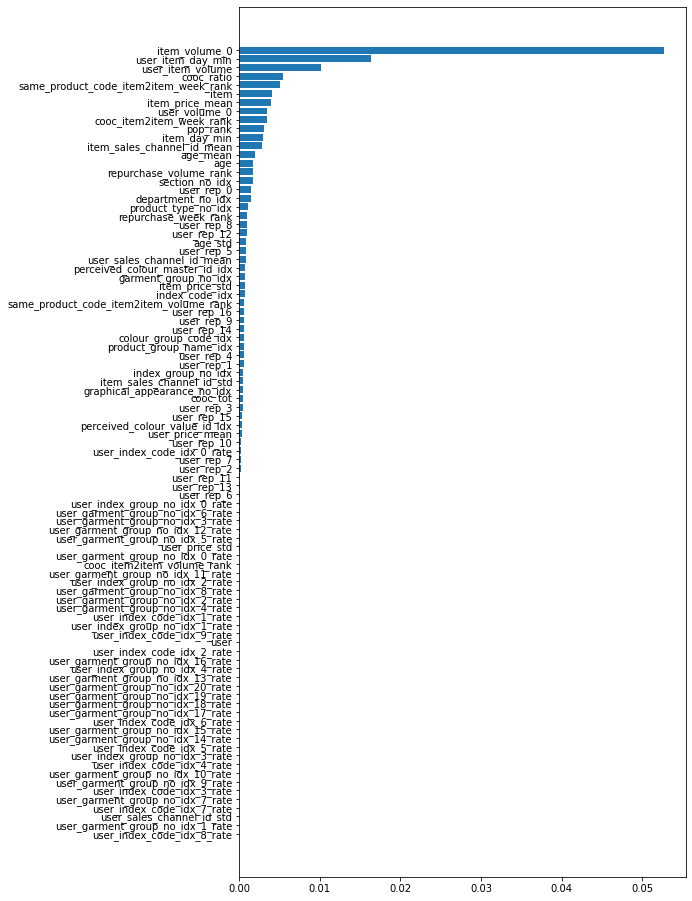

In [127]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train_tmp)
    train_dataset = lgb.Dataset(X_train, train_tmp['y'], group=group_train, feature_names=feature_columns)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_pool = catboost.Pool(data=X_train, label=train_tmp['y'], group_id=train_tmp['query_group'], cat_features=cat_features, feature_names=feature_columns)
    
    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

In [128]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [129]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    X_test = get_sparse(candidates, feature_columns)
    candidates['pred'] = model.predict(X_test)
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

week: 0
volume: 16323213
duplicates: 1.0408524306293947
            strategy   volume     ratio
0  same_product_code  9190204  0.563014
1                pop  3292752  0.201722
2         repurchase  2735882  0.167607
3               cooc  1104375  0.067657
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16357324
duplicates: 1.0406908620219617
            strategy   volume     ratio
0  same_product_code  9210520  0.563082
1                pop  3292752  0.201301
2         repurchase  2752227  0.168257
3               cooc  1101825  0.067360
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16262656
duplicates: 1.040703748961306
            strategy   volume     ratio
0  same_product_code  9167920  0.563741
1                pop  3292752  0.202473
2         repurchase  2708651  0.166556
3               cooc  1093333  0.067230
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16339038
duplicates: 1.0407942759824045
            strategy   volume     ratio
0  same_product_code  9204223  0.563327
1                pop  3292752  0.201527
2         repurchase  2737078  0.167518
3               cooc  1104985  0.067629
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16327766
duplicates: 1.040858820279775
            strategy   volume     ratio
0  same_product_code  9190841  0.562896
1                pop  3292752  0.201666
2         repurchase  2739307  0.167770
3               cooc  1104866  0.067668
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16393277
duplicates: 1.0409809223609503
            strategy   volume     ratio
0  same_product_code  9243785  0.563877
1                pop  3292752  0.200860
2         repurchase  2745003  0.167447
3               cooc  1111737  0.067817
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16283234
duplicates: 1.0412304848823601
            strategy   volume     ratio
0  same_product_code  9166138  0.562919
1                pop  3292752  0.202217
2         repurchase  2714357  0.166696
3               cooc  1109987  0.068167
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16302636
duplicates: 1.0409307608835499
            strategy   volume     ratio
0  same_product_code  9175200  0.562805
1                pop  3292752  0.201977
2         repurchase  2731902  0.167574
3               cooc  1102782  0.067644
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16232197
duplicates: 1.040590152079969
            strategy   volume     ratio
0  same_product_code  9136160  0.562842
1                pop  3292752  0.202853
2         repurchase  2711285  0.167031
3               cooc  1092000  0.067274
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

week: 0
volume: 16315699
duplicates: 1.0409364287833802
            strategy   volume     ratio
0  same_product_code  9189583  0.563236
1                pop  3292752  0.201815
2         repurchase  2730747  0.167369
3               cooc  1102617  0.067580
week: 0
processing index_code_idx
#unique values: 10


  0%|          | 0/10 [00:00<?, ?it/s]

processing index_group_no_idx
#unique values: 5


  0%|          | 0/5 [00:00<?, ?it/s]

processing garment_group_no_idx
#unique values: 21


  0%|          | 0/21 [00:00<?, ?it/s]

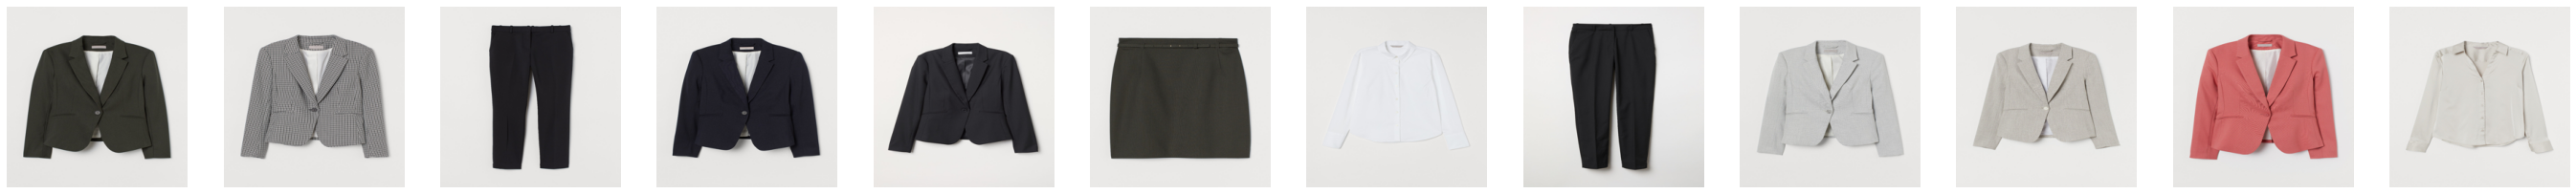

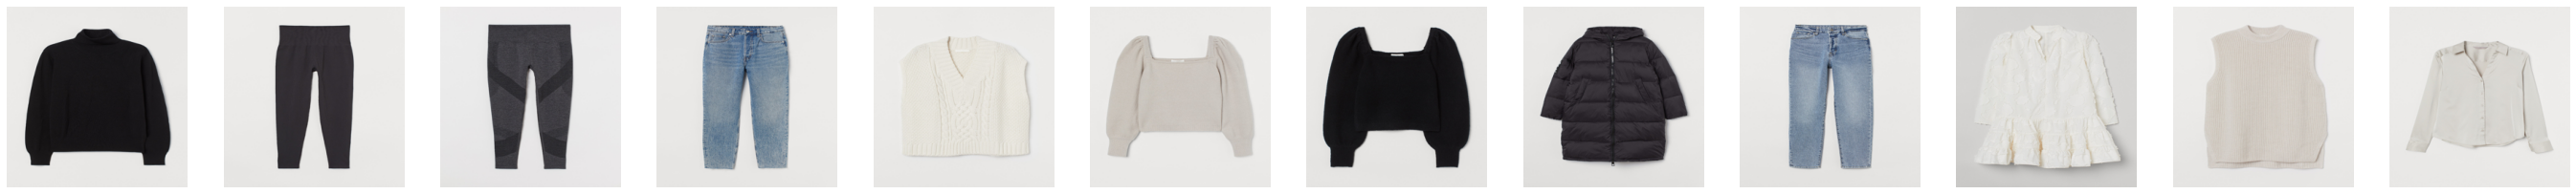

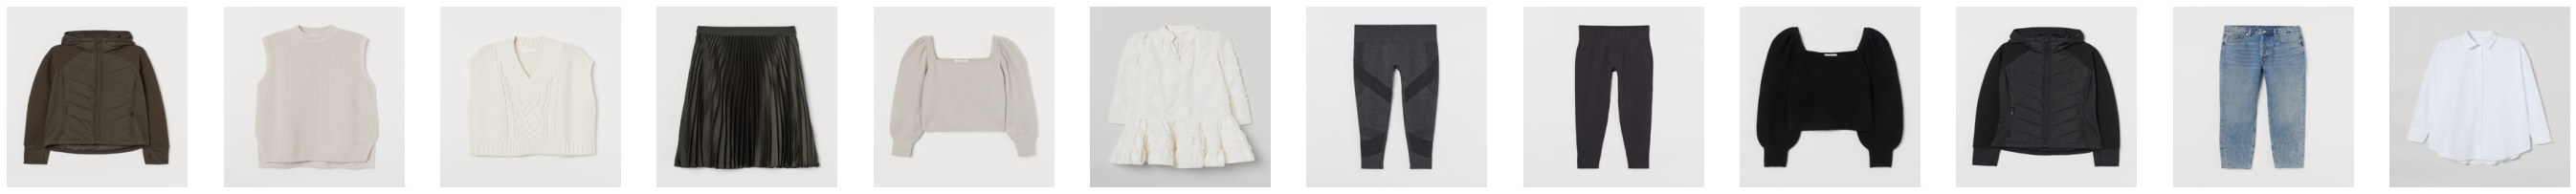

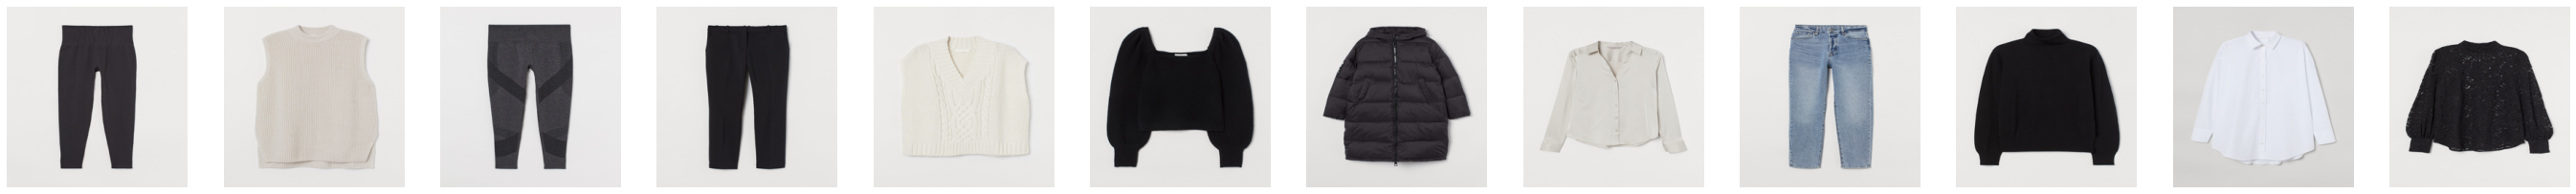

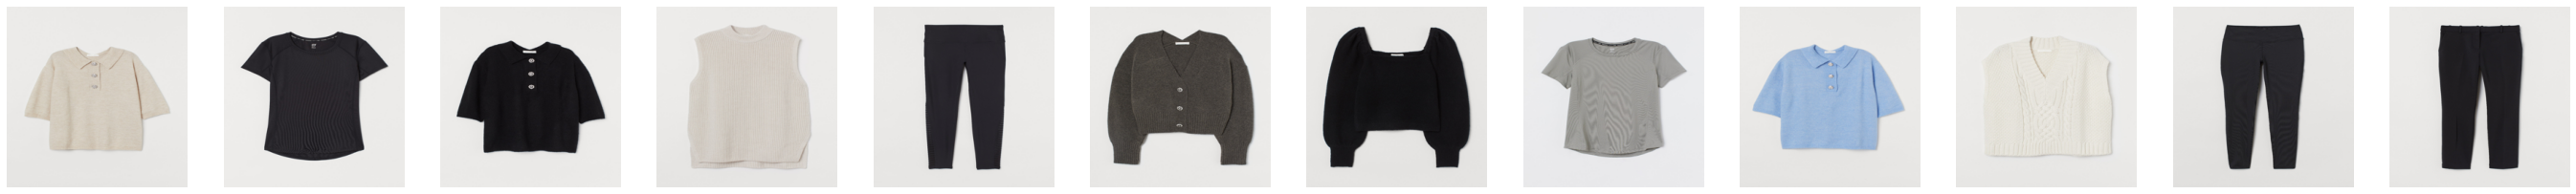

In [130]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [131]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0751471001 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0673677002 0866731001 0918292001 0448509014 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0924243001 0918522001 0851400020 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0924243001 0918292001 0751471001 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0791587001 0896152002 0924243001 07...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0804992014 0924243001 09...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846006 0762846026 0866731001 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846031 0762846006 0762846026 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0821395005 0714790028 09...


In [132]:
submission.to_csv('submission.csv', index=False)